### Set directories

In [1]:
import os
import re
from glob import glob
basedir = os.getcwd()
print(basedir)

names = []
names += glob(os.path.join(basedir, 'HRTF/IRC_*'))
print(names[0])

splitnames = [os.path.split(name) for name in names]
print(len(splitnames))

p = re.compile('IRC_\d{4,4}')
print(p)

subjects = [int(name[4:8]) for base, name in splitnames 
                         if not (p.match(name[-8:]) is None)]
print(subjects)

C:\Users\mynam\Documents\GitHub\Simultaneous-Sound-Localisation-Transformer
C:\Users\mynam\Documents\GitHub\Simultaneous-Sound-Localisation-Transformer\HRTF\IRC_1002
51
re.compile('IRC_\\d{4,4}')
[1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009, 1012, 1013, 1014, 1015, 1016, 1017, 1018, 1020, 1021, 1022, 1023, 1025, 1026, 1028, 1029, 1030, 1031, 1032, 1033, 1034, 1037, 1038, 1039, 1040, 1041, 1042, 1043, 1044, 1045, 1046, 1047, 1048, 1049, 1050, 1051, 1052, 1053, 1054, 1055, 1056, 1057, 1058, 1059]


### load data from .mat files

In [2]:
from scipy.io import loadmat

k=0
subject=subjects[k]

for k in range(len(names)):
    subject=subjects[k]
    # filename = os.path.join(names[k], 'IRC_' + str(subject))
    filename = os.path.join(names[k], 'COMPENSATED/MAT/HRIR/IRC_' + str(subject) + '_C_HRIR.mat')
#     print(filename)

### Create labels (azimuth, elevation)

dict_keys(['__header__', '__version__', '__globals__', 'r_eq_hrir_S', 'l_eq_hrir_S'])
(187, 2)
(2, 187, 512)


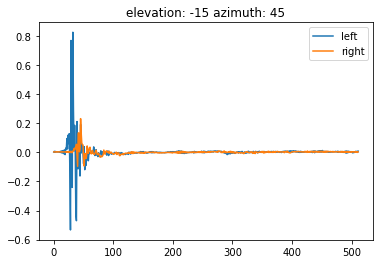

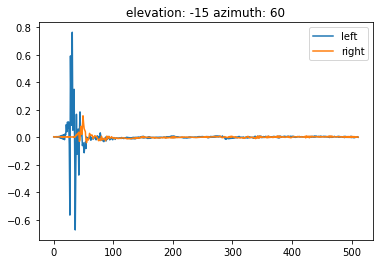

In [3]:
import numpy as np
import matplotlib.pyplot as plt 

m = loadmat(filename, struct_as_record=True)
print(m.keys())

l, r = m['l_eq_hrir_S'], m['r_eq_hrir_S']
hrirSet_l = l['content_m'][0][0]
hrirSet_r = r['content_m'][0][0]
elev=l['elev_v'][0][0]
azim=l['azim_v'][0][0]

label = np.hstack((elev, azim))
print(label.shape)

# 0: left 1: right
hrirSet = np.vstack((np.reshape(hrirSet_l, (1,) + hrirSet_l.shape),
                          np.reshape(hrirSet_r, (1,) + hrirSet_r.shape)))
print(hrirSet.shape)

for i in range(51,53):
    plt.plot(hrirSet[0, i, :])
    plt.plot(hrirSet[1, i, :])
    plt.legend(['left','right'], loc='best')
    plt.title('elevation: '+str(label[i, 0])+' azimuth: '+str(label[i, 1]))
    
    plt.show()


### Convolute audio signals with left-ear and right-ear HRIR

C:\Users\mynam\Documents\GitHub\Simultaneous-Sound-Localisation-Transformer
['C:\\Users\\mynam\\Documents\\GitHub\\Simultaneous-Sound-Localisation-Transformer\\audio\\84-121123-0000.flac', 'C:\\Users\\mynam\\Documents\\GitHub\\Simultaneous-Sound-Localisation-Transformer\\audio\\84-121123-0001.flac']
(33440,)
(2, 187, 33951)
(63840,)
(2, 187, 64351)


<ipython-input-53-d4a34ca71dca>:41: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  test = np.array(test)


ValueError: could not broadcast input array from shape (2,187,33951) into shape (2,187)

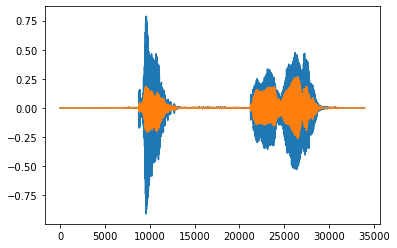

In [53]:
import soundfile as sf

print(basedir)
path = glob(os.path.join(basedir, 'audio/*'))
print(path)

audioIndex = -1
audioList = []
for audiopath in path:
    audioIndex += 1
    data, samplerate = sf.read(audiopath)
    print(data.shape)

    audio = data
    sigSeq = np.zeros((hrirSet.shape[0], hrirSet.shape[1], hrirSet.shape[2]+audio.size-1))
    print(sigSeq.shape)

    # hrirSet is of shape (2, 187, 512)
    for i in range(hrirSet.shape[1]):
        left = np.convolve(audio, hrirSet[0][i])
        right = np.convolve(audio, hrirSet[1][i])

        left = left.reshape(1, left.shape[0])
        right = right.reshape(1, right.shape[0])

        sigSeq[0][i] = left
        sigSeq[1][i] = right
    
    audioList.append(sigSeq)
    
#     plt.plot(data)
#     plt.show()
    
sliced = 150
plt.plot(audioList[0][0][sliced])
plt.plot(audioList[0][1][sliced])
# plt.show()

# test=np.array([audioList[0],audioList[1]])
test = [audioList[0], audioList[1]]
test = np.array(test)
print(test.shape)

In [49]:
import numpy as np
a = np.array([[[1, 1,1], [1, 1,1]]])
print(a.shape)
b = np.array([[[2, 2], [2, 2]]])
print(b.shape)
c = np.concatenate([a, b], axis=0)
print(c)
print(c.shape)

(1, 2, 3)
(1, 2, 2)


ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 2, the array at index 0 has size 3 and the array at index 1 has size 2

### Load data from .wav files (discarded)

In [23]:
import wave
import numpy as np


def _wav2array(nchannels, sampwidth, data):
    """data must be the string containing the bytes from the wav file."""
    num_samples, remainder = divmod(len(data), sampwidth * nchannels)
    if remainder > 0:
        raise ValueError('The length of data is not a multiple of '
                         'sampwidth * num_channels.')
    if sampwidth > 4:
        raise ValueError("sampwidth must not be greater than 4.")

    if sampwidth == 3:
        a = np.empty((num_samples, nchannels, 4), dtype=np.uint8)
        raw_bytes = np.frombuffer(data, dtype=np.uint8)
        a[:, :, :sampwidth] = raw_bytes.reshape(-1, nchannels, sampwidth)
        a[:, :, sampwidth:] = (a[:, :, sampwidth - 1:sampwidth] >> 7) * 255
        result = a.view('<i4').reshape(a.shape[:-1])
    else:
        # 8 bit samples are stored as unsigned ints; others as signed ints.
        dt_char = 'u' if sampwidth == 1 else 'i'
        a = np.frombuffer(data, dtype='<%s%d' % (dt_char, sampwidth))
        result = a.reshape(-1, nchannels)
    return result


def readwav(file):
    """
    Read a wav file.
    Returns the frame rate, sample width (in bytes) and a numpy array
    containing the data.
    This function does not read compressed wav files.
    """
    wav = wave.open(file)
    rate = wav.getframerate()
    nchannels = wav.getnchannels()
    sampwidth = wav.getsampwidth()
    nframes = wav.getnframes()
    data = wav.readframes(nframes)
    wav.close()
    array = _wav2array(nchannels, sampwidth, data)
    return rate, sampwidth, array


def writewav24(filename, rate, data):
    """Create a 24 bit wav file.
    data must be "array-like", either 1- or 2-dimensional.  If it is 2-d,
    the rows are the frames (i.e. samples) and the columns are the channels.
    The data is assumed to be signed, and the values are assumed to be
    within the range of a 24 bit integer.  Floating point values are
    converted to integers.  The data is not rescaled or normalized before
    writing it to the file.
    Example: Create a 3 second 440 Hz sine wave.
    >>> rate = 22050  # samples per second
    >>> T = 3         # sample duration (seconds)
    >>> f = 440.0     # sound frequency (Hz)
    >>> t = np.linspace(0, T, T*rate, endpoint=False)
    >>> x = (2**23 - 1) * np.sin(2 * np.pi * f * t)
    >>> writewav24("sine24.wav", rate, x)
    """
    a32 = np.asarray(data, dtype=np.int32)
    if a32.ndim == 1:
        # Convert to a 2D array with a single column.
        a32.shape = a32.shape + (1,)
    # By shifting first 0 bits, then 8, then 16, the resulting output
    # is 24 bit little-endian.
    a8 = (a32.reshape(a32.shape + (1,)) >> np.array([0, 8, 16])) & 255
    wavdata = a8.astype(np.uint8).tostring()

    w = wave.open(filename, 'wb')
    w.setnchannels(a32.shape[1])
    w.setsampwidth(3)
    w.setframerate(rate)
    w.writeframes(wavdata)
    w.close()

In [28]:
from scipy.io import wavfile

fs, sig, array = readwav('./HRTF/IRC_1002/RAW/WAV/IRC_1002_R/IRC_1002_R_R0195_T000_P000.wav')
print(fs, sig, array.shape)
print(array[0,0])

44100 3 (8192, 2)
-2976


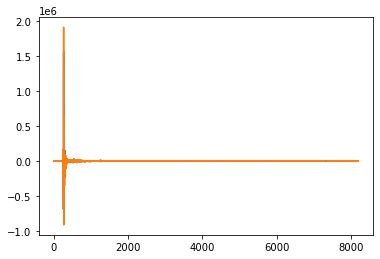

In [29]:
import matplotlib.pyplot as plt 

plt.plot(array[:,0])
plt.plot(array[:,1])
plt.show()
